# SPADE VAE-GAN

In this tutorial, we apply SPADE, a VAE-GAN-based neural network developed by Park et al. [1] that performs semantic image synthesis. We apply to a subset of BraTS [2] that we registered to MNI space and resampled to 2mm isotropic space. Segmentations of cerebrospinal fluid, grey and white matter, deep grey matter and brainstem were obtained using Geodesic Information Flows (GIF) [3].

[1] Park, T., Liu, M.-Y., Wang, T.-C., & Zhu, J.-Y. (2019). Semantic Image Synthesis with Spatially-Adaptive Normalization. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition.

[2] Menze, B. H., Jakab, A., Bauer, S., Kalpathy-Cramer, J., Farahani, K., Kirby, J., Burren, Y., Porz, N., Slotboom, J., Wiest, R., Lanczi, L., Gerstner, E., Weber, M.-A., Arbel, T., Avants, B. B., Ayache, N., Buendia, P., Collins, D. L., Cordier, N., … van Leemput, K. (2015). The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS). IEEE Transactions on Medical Imaging, 34(10), 1993–2024. https://doi.org/10.1109/TMI.2014.2377694

[3] Cardoso, M. J., Wolz, R., Modat, M., Fox, N. C., Rueckert, D., & Ourselin, S. (2012). Geodesic information flows. Medical Image Computing and Computer-Assisted Intervention : MICCAI ...  International Conference on Medical Image Computing and Computer-Assisted Intervention, 15(Pt 2), 262–270. https://doi.org/10.1007/978-3-642-33418-4_33

## Setup environment 

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import gdown" || pip install -q gdown
%matplotlib inline

## Setup imports

In [3]:
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path
import zipfile
import gdown
from monai.config import print_config
from monai.utils import set_determinism
from monai.data import DataLoader
from tqdm import tqdm
import numpy as np
import monai
import torch.nn.functional as F
from monai.networks.nets import SPADENet, MultiScalePatchDiscriminator
from monai.losses import  PatchAdversarialLoss, PerceptualLoss
from torch.cuda.amp import GradScaler, autocast

print_config()

MONAI version: 1.4.dev2431
Numpy version: 1.26.4
Pytorch version: 2.4.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 951a77d7a7737a3108afa94623a50b87d21eb4a7
MONAI __file__: /home/<username>/PycharmProjects/MONAI_tutorials/venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.14.0
Pillow version: 10.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 5.2.0
TorchVision version: 0.19.0+cu121
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.0.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VER

### Set deterministic training for reproducibility

In [4]:
set_determinism(42)

### Global hyperparameters

In [5]:
# INPUT PARAMETERS
input_shape = [128, 128]
batch_size = 6
num_workers = 4
num_epochs = 100
lambda_perc = 1.0
lambda_feat = 0.1
lambda_kld = 0.00001
loss_adv = 1.0

## Setup a data directory and download dataset

### Description of the data

The data for this notebook comes from the brain tumour segmentation challenge (BraTS) [1]. The images have been registered to MNI space using ANTsPy, and then subsampled to 2mm isotropic resolution. Geodesic Information Flows (GIF) [2] has been used to segment 5 regions: cerebrospinal fluid (CSF), grey matter (GM), white matter (WM), deep grey matter (DGM) and brainstem. Tumour sub-layers were delineated manually as part of the challenge source data. 
In this subset, we have only used one MRI modality , T1. 
Segmentations in this subset are merged and consist of the following labels: 0 (background), 1 (CSF), 2 (GM), 3 (WM), 4 (DGM), 5 (brainstem), 6 (brainstem), 7 (non GD-enahncing tumour core), 8 (peritumoural oedema), 9 (GD-enhancing tumour).

Citations:

[1] Menze, B. H., Jakab, A., Bauer, S., Kalpathy-Cramer, J., Farahani, K., Kirby, J., Burren, Y., Porz, N., Slotboom, J., Wiest, R., Lanczi, L., Gerstner, E., Weber, M. A., Arbel, T., Avants, B. B., Ayache, N., Buendia, P., Collins, D. L., Cordier, N., … van Leemput, K. (2015). The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS). IEEE Transactions on Medical Imaging, 34(10), 1993–2024. https://doi.org/10.1109/TMI.2014.2377694

[2] Cardoso MJ, Modat M, Wolz R, Melbourne A, Cash D, Rueckert D, Ourselin S. Geodesic Information Flows: Spatially-Variant Graphs and Their Application to Segmentation and Fusion. IEEE Trans Med Imaging. 2015 Sep;34(9):1976-88. doi: 10.1109/TMI.2015.2418298. Epub 2015 Apr 14. PMID: 25879909.


### Set-up a data directory

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = Path(root_dir)
print("Temporary directory used: %s " % root_dir)

Temporary directory used: /tmp/tmpyhiz6umk 


### Download data

In [7]:
# Comment if already downloaded!
gdown.download("https://drive.google.com/uc?id=1q87a9euo52eoFG37shPK0G5juq20x7-m", os.path.join(root_dir, "data.zip"))
#!gdown -O data.zip "https://drive.google.com/uc?id=1q87a9euo52eoFG37shPK0G5juq20x7-m" --remaining-ok

Downloading...
From (original): https://drive.google.com/uc?id=1q87a9euo52eoFG37shPK0G5juq20x7-m
From (redirected): https://drive.google.com/uc?id=1q87a9euo52eoFG37shPK0G5juq20x7-m&confirm=t&uuid=ea027357-5f65-485c-8509-acd9c7223f67
To: /tmp/tmpyhiz6umk/data.zip
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26.7M/26.7M [00:00<00:00, 34.7MB/s]


'/tmp/tmpyhiz6umk/data.zip'

We extract and reorganise the data into the relevant sub-folders:

In [8]:
zip_obj = zipfile.ZipFile(os.path.join(root_dir, "data.zip"), "r")
zip_obj.extractall(root_dir)
images_T1 = root_dir / "BRATS_SUBS2_SUBSET/T1"
labels = root_dir / "BRATS_SUBS2_SUBSET/Parcellations"

## Prepare dataloaders

In [9]:
# INPUT PARAMETERS
input_shape = [128, 128]
batch_size = 4
num_workers = 2

In [10]:
# We create the data dictionaries that we need
all_images = [os.path.join(images_T1, i) for i in os.listdir(images_T1)]
np.random.shuffle(all_images)
corresponding_labels = [
    os.path.join(labels, i.split("/")[-1].replace(i.split("/")[-1].split("_")[0], "Parcellation")) for i in all_images
]
input_dict = [{"image": i, "label": corresponding_labels[ind]} for ind, i in enumerate(all_images)]
input_dict_train = input_dict[: int(len(input_dict) * 0.9)]
input_dict_val = input_dict[int(len(input_dict) * 0.9) :]

We define the relevant transforms:

In [11]:
preliminar_shape = input_shape + [50]  # We take random slices fron the center of the brain
crop_shape = input_shape + [1]
base_transforms = [
    monai.transforms.LoadImaged(keys=["label", "image"]),
    monai.transforms.EnsureChannelFirstd(keys=["image", "label"]),
    monai.transforms.CenterSpatialCropd(keys=["label", "image"], roi_size=preliminar_shape),
    monai.transforms.RandSpatialCropd(keys=["label", "image"], roi_size=crop_shape, max_roi_size=crop_shape),
    monai.transforms.SqueezeDimd(keys=["label", "image"], dim=-1),
    monai.transforms.Resized(keys=["image", "label"], spatial_size=input_shape),
]
last_transforms = [
    monai.transforms.CopyItemsd(keys=["label"], names=["label_channel"]),
    monai.transforms.Lambdad(keys=["label_channel"], func=lambda l: l != 0),
    monai.transforms.MaskIntensityd(keys=["image"], mask_key="label_channel"),
    monai.transforms.NormalizeIntensityd(keys=["image"]),
    monai.transforms.ToTensord(keys=["image", "label"]),
]

aug_transforms = [
    monai.transforms.RandBiasFieldd(coeff_range=(0, 0.005), prob=0.33, keys=["image"]),
    monai.transforms.RandAdjustContrastd(gamma=(0.9, 1.15), prob=0.33, keys=["image"]),
    monai.transforms.RandGaussianNoised(prob=0.33, mean=0.0, std=np.random.uniform(0.005, 0.015), keys=["image"]),
    monai.transforms.RandAffined(
        rotate_range=[-0.05, 0.05],
        shear_range=[0.001, 0.05],
        scale_range=[0, 0.05],
        padding_mode="zeros",
        mode="nearest",
        prob=0.33,
        keys=["label", "image"],
    ),
]

We create the dataset and dataloader:

In [12]:
train_transforms = monai.transforms.Compose(base_transforms + aug_transforms + last_transforms)
val_transforms = monai.transforms.Compose(base_transforms + last_transforms)

train_dataset = monai.data.dataset.Dataset(input_dict_train, train_transforms)
val_dataset = monai.data.dataset.Dataset(input_dict_val, val_transforms)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
val_loader = DataLoader(val_dataset, shuffle=False, drop_last=False, batch_size=batch_size, num_workers=num_workers)

We do a sanity check and plot an element of the dataset:

torch.Size([4, 1, 128, 128])


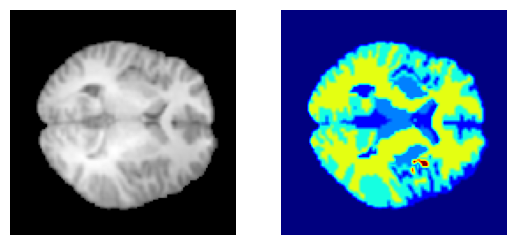

In [13]:
# Sanity check
batch = next(iter(train_loader))
print(batch["image"].shape)
plt.subplot(1, 2, 1)
plt.imshow(batch["image"][0, 0, ...], cmap="gist_gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(batch["label"][0, 0, ...], cmap="jet")
plt.axis("off")
plt.show()

### Networks creation and losses

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
def one_hot(input_label, label_nc):
    # One hot encoding function for the labels
    shape_ = list(input_label.shape)
    shape_[1] = label_nc
    label_out = torch.zeros(shape_)
    for channel in range(label_nc):
        label_out[:, channel, ...] = input_label[:, 0, ...] == channel
    return label_out

In [16]:
def picture_results(input_label, input_image, output_image):
    f = plt.figure(figsize=(4, 1.5))
    plt.subplot(1, 3, 1)
    plt.imshow(torch.argmax(input_label, 1)[0, ...].detach().cpu(), cmap="jet")
    plt.axis("off")
    plt.title("Label")
    plt.subplot(1, 3, 2)
    plt.imshow(input_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Input image")
    plt.subplot(1, 3, 3)
    plt.imshow(output_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Output image")
    plt.show()

We define the KLD loss that we need to ensure that the latent space is Gaussian distributed [5].

[5] Kingma, D. P., & Welling, M. (2014). Auto-Encoding Variational Bayes. CoRR, abs/1312.6.

In [17]:
class KLDLoss(torch.nn.Module):
    """
    Computes the Kullback-Leibler divergence between a normal distribution with mean mu and variance logvar and
     one with mean 0 and variance 1.
    """

    def forward(self, mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


The SPADE paper includes a feature loss which acts like a regulariser of the discriminator. 

In [18]:
def feature_loss(input_features_disc_fake, input_features_disc_real, lambda_feat, device):
    criterion = torch.nn.L1Loss()
    num_D = len(input_features_disc_fake)
    GAN_Feat_loss = torch.zeros(1).to(device)
    for i in range(num_D):  # for each discriminator
        num_intermediate_outputs = len(input_features_disc_fake[i])
        for j in range(num_intermediate_outputs):  # for each layer output
            unweighted_loss = criterion(input_features_disc_fake[i][j], input_features_disc_real[i][j].detach())
            GAN_Feat_loss += unweighted_loss * lambda_feat / num_D
    return GAN_Feat_loss

SPADE can be used as a GAN, for which only a decoder is necessary, or a VAE-GAN, which includes an image ("style") encoder. The decoder incorporates special normalisation blocks called "SPADE" blocks. They take the semantic map and obtain rich features to normalise the activations per semantic layer.

In [34]:
net = SPADENet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    label_nc=10,
    input_shape=input_shape,
    channels=[16, 32, 64],
    z_dim=8,
    is_vae=True,
)

SPADE is trained as a GAN network, and therefore, requires a discriminator. In Park's paper, a multi-scale patch-GAN discriminator is used.

In [41]:
discriminator = MultiScalePatchDiscriminator(
    num_d=2,
    num_layers_d=3,
    spatial_dims=2,
    channels=8,
    in_channels=11,
    out_channels=11,
    minimum_size_im=128,
    norm="INSTANCE",
    kernel_size=3,
)

adversarial_loss = PatchAdversarialLoss(reduction="sum", criterion="hinge")

Like in the paper, we also define a perceptual loss:

In [42]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="vgg", is_fake_3d=False, pretrained=True)
perceptual_loss = perceptual_loss.to(device)

In [43]:
kld_loss = KLDLoss()

In [44]:
optimizer_G = torch.optim.Adam(net.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0004)

## Training the network

We train the network on the following loss: a KLD loss to normalise the latent space, the adversarial multi-scale patch-GAN loss, the regularising feature loss and the perceptual loss. The training parameters have to be defined in the following box:

Epoch 0/100


  0%|                | 0/1 [00:00<?, ?it/s, kld=197, perceptual=0.44, generator=2.04, feature=0.154, discriminator=3.98]

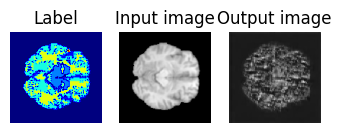

100%|████████| 1/1 [00:00<00:00,  2.93it/s, kld=197, perceptual=0.44, generator=2.04, feature=0.154, discriminator=3.98]

Epoch 1/100



100%|███████| 1/1 [00:00<00:00,  4.14it/s, kld=308, perceptual=0.412, generator=2.03, feature=0.134, discriminator=3.94]

Epoch 2/100



100%|███████| 1/1 [00:00<00:00,  4.25it/s, kld=223, perceptual=0.384, generator=2.02, feature=0.138, discriminator=3.89]

Epoch 3/100



100%|███████| 1/1 [00:00<00:00,  4.16it/s, kld=143, perceptual=0.332, generator=2.23, feature=0.149, discriminator=3.69]

Epoch 4/100



100%|███████| 1/1 [00:00<00:00,  4.02it/s, kld=159, perceptual=0.351, generator=2.38, feature=0.182, discriminator=3.59]

Epoch 5/100



100%|███████| 1/1 [00:00<00:00,  3.93it/s, kld=163, perceptual=0.329, generator=2.12, feature=0.154, discriminator=3.67]

Epoch 6/100



100%|███████| 1/1 [00:00<00:00,  3.81it/s, kld=297, perceptual=0.378, generator=2.54, feature=0.208, discriminator=3.01]

Epoch 7/100



100%|███████| 1/1 [00:00<00:00,  4.17it/s, kld=233, perceptual=0.327, generator=2.56, feature=0.186, discriminator=3.09]

Epoch 8/100



100%|███████| 1/1 [00:00<00:00,  3.98it/s, kld=162, perceptual=0.291, generator=2.57, feature=0.184, discriminator=2.83]

Epoch 9/100



100%|███████| 1/1 [00:00<00:00,  2.61it/s, kld=149, perceptual=0.341, generator=2.77, feature=0.232, discriminator=2.56]

Epoch 10/100



  0%|               | 0/1 [00:00<?, ?it/s, kld=154, perceptual=0.368, generator=2.83, feature=0.248, discriminator=2.44]

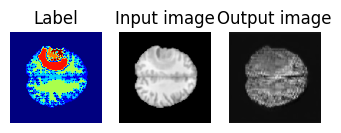

100%|███████| 1/1 [00:00<00:00,  2.83it/s, kld=154, perceptual=0.368, generator=2.83, feature=0.248, discriminator=2.44]

Epoch 11/100



100%|███████| 1/1 [00:00<00:00,  4.24it/s, kld=155, perceptual=0.354, generator=2.84, feature=0.226, discriminator=2.63]

Epoch 12/100



100%|███████| 1/1 [00:00<00:00,  4.13it/s, kld=213, perceptual=0.312, generator=2.88, feature=0.155, discriminator=3.13]

Epoch 13/100



100%|███████| 1/1 [00:00<00:00,  4.17it/s, kld=232, perceptual=0.312, generator=2.09, feature=0.176, discriminator=3.01]

Epoch 14/100



100%|███████| 1/1 [00:00<00:00,  4.09it/s, kld=147, perceptual=0.346, generator=3.02, feature=0.186, discriminator=2.63]

Epoch 15/100



100%|███████| 1/1 [00:00<00:00,  4.09it/s, kld=157, perceptual=0.393, generator=3.01, feature=0.195, discriminator=2.55]

Epoch 16/100



100%|████████| 1/1 [00:00<00:00,  3.84it/s, kld=122, perceptual=0.38, generator=3.05, feature=0.158, discriminator=2.85]

Epoch 17/100



100%|███████| 1/1 [00:00<00:00,  4.09it/s, kld=180, perceptual=0.443, generator=2.61, feature=0.206, discriminator=2.37]

Epoch 18/100



100%|████████| 1/1 [00:00<00:00,  4.32it/s, kld=122, perceptual=0.408, generator=2.45, feature=0.141, discriminator=3.1]

Epoch 19/100



100%|███████| 1/1 [00:00<00:00,  3.54it/s, kld=348, perceptual=0.413, generator=2.63, feature=0.177, discriminator=2.74]

Epoch 20/100



  0%|               | 0/1 [00:00<?, ?it/s, kld=512, perceptual=0.375, generator=2.6, feature=0.0954, discriminator=3.71]

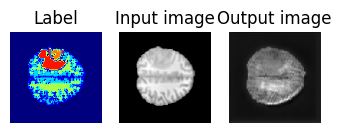

100%|███████| 1/1 [00:00<00:00,  1.62it/s, kld=512, perceptual=0.375, generator=2.6, feature=0.0954, discriminator=3.71]

Epoch 21/100



100%|████████| 1/1 [00:00<00:00,  4.14it/s, kld=620, perceptual=0.444, generator=2.7, feature=0.157, discriminator=3.52]

Epoch 22/100



100%|███████| 1/1 [00:00<00:00,  4.15it/s, kld=647, perceptual=0.408, generator=2.77, feature=0.141, discriminator=3.39]

Epoch 23/100



100%|███████| 1/1 [00:00<00:00,  4.28it/s, kld=493, perceptual=0.413, generator=2.74, feature=0.165, discriminator=2.85]

Epoch 24/100



100%|███████| 1/1 [00:00<00:00,  4.18it/s, kld=342, perceptual=0.354, generator=2.83, feature=0.129, discriminator=2.98]

Epoch 25/100



100%|███████| 1/1 [00:00<00:00,  4.30it/s, kld=308, perceptual=0.409, generator=2.86, feature=0.186, discriminator=2.28]

Epoch 26/100



100%|████████| 1/1 [00:00<00:00,  3.94it/s, kld=244, perceptual=0.413, generator=2.88, feature=0.177, discriminator=2.4]

Epoch 27/100



100%|█████████| 1/1 [00:00<00:00,  4.12it/s, kld=160, perceptual=0.37, generator=3.07, feature=0.184, discriminator=2.5]

Epoch 28/100



100%|███████| 1/1 [00:00<00:00,  4.18it/s, kld=158, perceptual=0.405, generator=2.69, feature=0.192, discriminator=2.16]

Epoch 29/100



100%|████████| 1/1 [00:00<00:00,  4.25it/s, kld=218, perceptual=0.398, generator=2.66, feature=0.179, discriminator=2.2]

Epoch 30/100



  0%|               | 0/1 [00:00<?, ?it/s, kld=229, perceptual=0.379, generator=2.92, feature=0.182, discriminator=2.14]

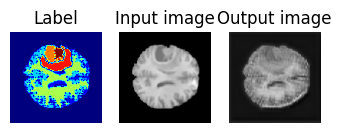

100%|███████| 1/1 [00:00<00:00,  2.59it/s, kld=229, perceptual=0.379, generator=2.92, feature=0.182, discriminator=2.14]

Epoch 31/100



100%|████████| 1/1 [00:00<00:00,  4.22it/s, kld=342, perceptual=0.378, generator=2.74, feature=0.175, discriminator=2.3]

Epoch 32/100



100%|███████| 1/1 [00:00<00:00,  3.64it/s, kld=243, perceptual=0.359, generator=2.91, feature=0.169, discriminator=2.29]

Epoch 33/100



100%|█████████| 1/1 [00:00<00:00,  4.16it/s, kld=212, perceptual=0.396, generator=2.9, feature=0.18, discriminator=2.07]

Epoch 34/100



100%|███████| 1/1 [00:00<00:00,  4.19it/s, kld=206, perceptual=0.388, generator=2.74, feature=0.188, discriminator=2.07]

Epoch 35/100



100%|██████████| 1/1 [00:00<00:00,  4.34it/s, kld=134, perceptual=0.35, generator=3.03, feature=0.2, discriminator=2.07]

Epoch 36/100



100%|███████| 1/1 [00:00<00:00,  4.30it/s, kld=210, perceptual=0.379, generator=2.94, feature=0.211, discriminator=1.89]

Epoch 37/100



100%|███████| 1/1 [00:00<00:00,  4.15it/s, kld=198, perceptual=0.353, generator=2.97, feature=0.179, discriminator=1.84]

Epoch 38/100



100%|██████████| 1/1 [00:00<00:00,  4.23it/s, kld=171, perceptual=0.368, generator=2.45, feature=0.119, discriminator=3]

Epoch 39/100



100%|███████| 1/1 [00:00<00:00,  4.26it/s, kld=153, perceptual=0.407, generator=2.74, feature=0.164, discriminator=2.13]

Epoch 40/100



  0%|                 | 0/1 [00:00<?, ?it/s, kld=125, perceptual=0.406, generator=2.94, feature=0.21, discriminator=1.9]

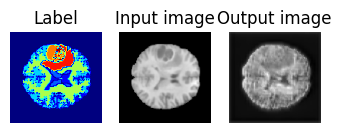

100%|█████████| 1/1 [00:00<00:00,  2.94it/s, kld=125, perceptual=0.406, generator=2.94, feature=0.21, discriminator=1.9]

Epoch 41/100



100%|████████| 1/1 [00:00<00:00,  4.27it/s, kld=217, perceptual=0.41, generator=2.89, feature=0.227, discriminator=1.96]

Epoch 42/100



100%|████████| 1/1 [00:00<00:00,  4.39it/s, kld=285, perceptual=0.39, generator=3.04, feature=0.217, discriminator=1.87]

Epoch 43/100



100%|███████| 1/1 [00:00<00:00,  4.04it/s, kld=354, perceptual=0.397, generator=2.86, feature=0.211, discriminator=1.96]

Epoch 44/100



100%|███████| 1/1 [00:00<00:00,  4.03it/s, kld=216, perceptual=0.368, generator=2.92, feature=0.193, discriminator=1.96]

Epoch 45/100



100%|███████| 1/1 [00:00<00:00,  4.23it/s, kld=155, perceptual=0.361, generator=2.69, feature=0.184, discriminator=2.24]

Epoch 46/100



100%|███████| 1/1 [00:00<00:00,  4.12it/s, kld=167, perceptual=0.327, generator=2.71, feature=0.181, discriminator=2.29]

Epoch 47/100



100%|███████| 1/1 [00:00<00:00,  3.71it/s, kld=148, perceptual=0.329, generator=2.75, feature=0.172, discriminator=2.25]

Epoch 48/100



100%|███████| 1/1 [00:00<00:00,  4.33it/s, kld=133, perceptual=0.334, generator=2.73, feature=0.183, discriminator=2.13]

Epoch 49/100



100%|███████| 1/1 [00:00<00:00,  3.85it/s, kld=125, perceptual=0.351, generator=2.75, feature=0.189, discriminator=2.04]

Epoch 50/100



  0%|                | 0/1 [00:00<?, ?it/s, kld=100, perceptual=0.385, generator=2.58, feature=0.18, discriminator=2.16]

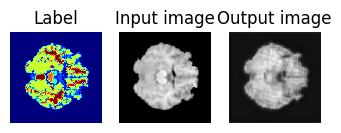

100%|████████| 1/1 [00:00<00:00,  2.11it/s, kld=100, perceptual=0.385, generator=2.58, feature=0.18, discriminator=2.16]

Epoch 51/100



100%|███████| 1/1 [00:00<00:00,  4.25it/s, kld=193, perceptual=0.366, generator=2.79, feature=0.169, discriminator=1.99]

Epoch 52/100



100%|███████| 1/1 [00:00<00:00,  4.08it/s, kld=281, perceptual=0.323, generator=2.89, feature=0.174, discriminator=1.91]

Epoch 53/100



100%|███████| 1/1 [00:00<00:00,  4.26it/s, kld=266, perceptual=0.312, generator=2.59, feature=0.125, discriminator=2.61]

Epoch 54/100



100%|██████| 1/1 [00:00<00:00,  4.31it/s, kld=396, perceptual=0.307, generator=2.99, feature=0.0788, discriminator=3.61]

Epoch 55/100



100%|██████| 1/1 [00:00<00:00,  4.23it/s, kld=410, perceptual=0.311, generator=2.59, feature=0.0682, discriminator=3.41]

Epoch 56/100



100%|██████| 1/1 [00:00<00:00,  4.18it/s, kld=936, perceptual=0.324, generator=2.95, feature=0.0999, discriminator=3.35]

Epoch 57/100



100%|████████| 1/1 [00:00<00:00,  4.13it/s, kld=973, perceptual=0.31, generator=2.67, feature=0.106, discriminator=3.21]

Epoch 58/100



100%|█████████| 1/1 [00:00<00:00,  4.09it/s, kld=675, perceptual=0.3, generator=2.74, feature=0.104, discriminator=3.18]

Epoch 59/100



100%|███████| 1/1 [00:00<00:00,  4.03it/s, kld=411, perceptual=0.347, generator=2.31, feature=0.0562, discriminator=3.5]

Epoch 60/100



  0%|              | 0/1 [00:00<?, ?it/s, kld=238, perceptual=0.304, generator=2.59, feature=0.0719, discriminator=3.13]

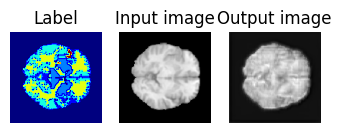

100%|██████| 1/1 [00:00<00:00,  2.95it/s, kld=238, perceptual=0.304, generator=2.59, feature=0.0719, discriminator=3.13]

Epoch 61/100



100%|██████| 1/1 [00:00<00:00,  4.06it/s, kld=303, perceptual=0.298, generator=2.61, feature=0.0632, discriminator=3.09]

Epoch 62/100



100%|███████| 1/1 [00:00<00:00,  3.79it/s, kld=286, perceptual=0.28, generator=2.57, feature=0.0978, discriminator=3.18]

Epoch 63/100



100%|███████| 1/1 [00:00<00:00,  4.15it/s, kld=524, perceptual=0.347, generator=2.81, feature=0.129, discriminator=2.56]

Epoch 64/100



100%|████████| 1/1 [00:00<00:00,  4.34it/s, kld=550, perceptual=0.291, generator=2.95, feature=0.13, discriminator=2.57]

Epoch 65/100



100%|████████| 1/1 [00:00<00:00,  4.27it/s, kld=436, perceptual=0.321, generator=2.57, feature=0.12, discriminator=2.72]

Epoch 66/100



100%|███████| 1/1 [00:00<00:00,  4.26it/s, kld=372, perceptual=0.364, generator=2.87, feature=0.125, discriminator=2.36]

Epoch 67/100



100%|███████| 1/1 [00:00<00:00,  4.19it/s, kld=421, perceptual=0.342, generator=3.01, feature=0.147, discriminator=2.09]

Epoch 68/100



100%|███████| 1/1 [00:00<00:00,  4.00it/s, kld=244, perceptual=0.342, generator=2.96, feature=0.144, discriminator=2.09]

Epoch 69/100



100%|███████| 1/1 [00:00<00:00,  4.20it/s, kld=229, perceptual=0.329, generator=3.02, feature=0.141, discriminator=1.98]

Epoch 70/100



  0%|                 | 0/1 [00:00<?, ?it/s, kld=134, perceptual=0.335, generator=2.87, feature=0.14, discriminator=2.1]

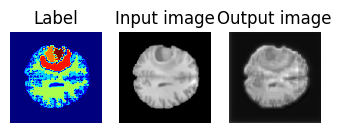

100%|█████████| 1/1 [00:00<00:00,  3.04it/s, kld=134, perceptual=0.335, generator=2.87, feature=0.14, discriminator=2.1]

Epoch 71/100



100%|███████| 1/1 [00:00<00:00,  4.21it/s, kld=196, perceptual=0.307, generator=2.86, feature=0.148, discriminator=2.13]

Epoch 72/100



100%|███████| 1/1 [00:00<00:00,  4.19it/s, kld=191, perceptual=0.312, generator=2.98, feature=0.134, discriminator=1.96]

Epoch 73/100



100%|████████| 1/1 [00:00<00:00,  4.30it/s, kld=205, perceptual=0.286, generator=2.89, feature=0.131, discriminator=2.2]

Epoch 74/100



100%|████████| 1/1 [00:00<00:00,  4.24it/s, kld=261, perceptual=0.33, generator=2.94, feature=0.128, discriminator=2.02]

Epoch 75/100



100%|███████| 1/1 [00:00<00:00,  4.31it/s, kld=174, perceptual=0.296, generator=2.88, feature=0.129, discriminator=2.14]

Epoch 76/100



100%|███████| 1/1 [00:00<00:00,  4.11it/s, kld=144, perceptual=0.318, generator=2.88, feature=0.131, discriminator=2.06]

Epoch 77/100



100%|███████| 1/1 [00:00<00:00,  4.18it/s, kld=427, perceptual=0.287, generator=2.77, feature=0.113, discriminator=2.31]

Epoch 78/100



100%|███████| 1/1 [00:00<00:00,  4.16it/s, kld=907, perceptual=0.304, generator=2.81, feature=0.111, discriminator=2.28]

Epoch 79/100



100%|██████| 1/1 [00:00<00:00,  4.11it/s, kld=958, perceptual=0.279, generator=1.81, feature=0.0612, discriminator=3.32]

Epoch 80/100



  0%|              | 0/1 [00:00<?, ?it/s, kld=669, perceptual=0.312, generator=1.73, feature=0.0602, discriminator=3.33]

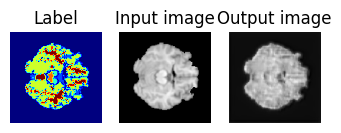

100%|██████| 1/1 [00:00<00:00,  3.00it/s, kld=669, perceptual=0.312, generator=1.73, feature=0.0602, discriminator=3.33]

Epoch 81/100



100%|███████| 1/1 [00:00<00:00,  4.19it/s, kld=378, perceptual=0.244, generator=1.78, feature=0.0594, discriminator=3.5]

Epoch 82/100



100%|████████| 1/1 [00:00<00:00,  4.20it/s, kld=236, perceptual=0.285, generator=1.87, feature=0.07, discriminator=3.48]

Epoch 83/100



100%|███████| 1/1 [00:00<00:00,  4.22it/s, kld=238, perceptual=0.303, generator=1.7, feature=0.0699, discriminator=3.33]

Epoch 84/100



100%|███████| 1/1 [00:00<00:00,  4.34it/s, kld=294, perceptual=0.298, generator=1.16, feature=0.041, discriminator=3.83]

Epoch 85/100



100%|████████| 1/1 [00:00<00:00,  4.25it/s, kld=454, perceptual=0.251, generator=1.5, feature=0.043, discriminator=3.92]

Epoch 86/100



100%|██████| 1/1 [00:00<00:00,  4.11it/s, kld=340, perceptual=0.312, generator=1.53, feature=0.0516, discriminator=3.83]

Epoch 87/100



100%|███████| 1/1 [00:00<00:00,  4.31it/s, kld=314, perceptual=0.253, generator=1.41, feature=0.0447, discriminator=3.7]

Epoch 88/100



100%|███████| 1/1 [00:00<00:00,  4.07it/s, kld=254, perceptual=0.247, generator=1.81, feature=0.056, discriminator=3.62]

Epoch 89/100



100%|███████| 1/1 [00:00<00:00,  3.97it/s, kld=313, perceptual=0.27, generator=1.61, feature=0.0621, discriminator=3.73]

Epoch 90/100



  0%|              | 0/1 [00:00<?, ?it/s, kld=373, perceptual=0.287, generator=1.54, feature=0.0439, discriminator=3.77]

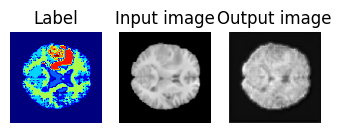

100%|██████| 1/1 [00:00<00:00,  2.95it/s, kld=373, perceptual=0.287, generator=1.54, feature=0.0439, discriminator=3.77]

Epoch 91/100



100%|███████| 1/1 [00:00<00:00,  4.18it/s, kld=343, perceptual=0.304, generator=1.48, feature=0.044, discriminator=3.63]

Epoch 92/100



100%|██████| 1/1 [00:00<00:00,  4.14it/s, kld=225, perceptual=0.287, generator=1.61, feature=0.0527, discriminator=3.55]

Epoch 93/100



100%|██████| 1/1 [00:00<00:00,  4.14it/s, kld=273, perceptual=0.287, generator=1.21, feature=0.0417, discriminator=3.81]

Epoch 94/100



100%|██████| 1/1 [00:00<00:00,  4.11it/s, kld=268, perceptual=0.257, generator=1.42, feature=0.0459, discriminator=3.87]

Epoch 95/100



100%|████████| 1/1 [00:00<00:00,  4.16it/s, kld=218, perceptual=0.27, generator=1.93, feature=0.072, discriminator=3.55]

Epoch 96/100



100%|██████| 1/1 [00:00<00:00,  3.74it/s, kld=312, perceptual=0.271, generator=1.83, feature=0.0558, discriminator=3.66]

Epoch 97/100



100%|██████| 1/1 [00:00<00:00,  4.39it/s, kld=307, perceptual=0.261, generator=1.47, feature=0.0533, discriminator=3.71]

Epoch 98/100



100%|██████| 1/1 [00:00<00:00,  3.33it/s, kld=296, perceptual=0.288, generator=1.63, feature=0.0432, discriminator=3.58]

Epoch 99/100



100%|██████| 1/1 [00:00<00:00,  4.40it/s, kld=274, perceptual=0.266, generator=1.09, feature=0.0412, discriminator=3.88]


In [45]:
net = net.to(device)
discriminator = discriminator.to(device)
torch.autograd.set_detect_anomaly(True)
losses = {"kld": [], "perceptual": [], "feature": [], "generator": [], "discriminator": []}
losses_val = {"kld": [], "perceptual": [], "feature": [], "generator": [], "discriminator": []}
for epoch in range(num_epochs):
    print("Epoch %d/%d" % (epoch, num_epochs))
    train_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=120)
    losses_epoch = {"kld": 0, "perceptual": 0, "feature": 0, "generator": 0, "discriminator": 0}
    for step, d in train_bar:
        image = d["image"].to(device)
        with torch.no_grad():
            label = one_hot(d["label"], 10).to(device)
        optimizer_G.zero_grad()

        # Losses gen
        out, mu, logvar = net(label, image)
        kld_ = kld_loss(mu, logvar)
        disc_fakes, features_fakes = discriminator(torch.cat([out, label], 1))
        loss_g = adversarial_loss(disc_fakes, target_is_real=True, for_discriminator=False)
        disc_reals, features_reals = discriminator(torch.cat([image, label], 1))
        loss_feat = feature_loss(features_fakes, features_reals, lambda_feat, device)
        loss_perc = perceptual_loss(out, target=image)
        total_loss = loss_g + loss_perc * lambda_perc + kld_ * lambda_kld + loss_feat * lambda_feat
        total_loss.backward(retain_graph=True)
        optimizer_G.step()

        # Store
        losses_epoch["kld"] += kld_.item()
        losses_epoch["perceptual"] += loss_perc.item()
        losses_epoch["generator"] += loss_g.item()
        # Train disc
        out, _, _ = net(label, image)
        disc_fakes, _ = discriminator(torch.cat([out, label], 1))
        loss_d_r = adversarial_loss(disc_reals, target_is_real=True, for_discriminator=True)
        loss_g_f = adversarial_loss(disc_fakes, target_is_real=False, for_discriminator=True)
        optimizer_D.zero_grad()
        loss_d = loss_d_r + loss_g_f
        loss_d.backward()
        optimizer_D.step()

        # Store
        losses_epoch["feature"] = loss_feat.item()
        losses_epoch["discriminator"] = loss_d_r.item() + loss_g_f.item()

        train_bar.set_postfix(
            {
                "kld": kld_.item(),
                "perceptual": loss_perc.item(),
                "generator": loss_g.item(),
                "feature": loss_feat.item(),
                "discriminator": loss_d_r.item() + loss_g_f.item(),
            }
        )

    val_bar = tqdm(enumerate(val_loader), total=len(val_loader), ncols=120)
    losses_epoch_val = {"kld": 0, "perceptual": 0, "feature": 0, "generator": 0, "discriminator": 0}
    for step, d in val_bar:
        image = d["image"].to(device)
        with torch.no_grad():
            label = one_hot(d["label"], 10).to(device)
            # Losses gen
            out, mu, logvar = net(label, image)
            kld_ = kld_loss(mu, logvar)
            disc_fakes, features_fakes = discriminator(torch.cat([out, label], 1))
            loss_g = adversarial_loss(disc_fakes, target_is_real=True, for_discriminator=False)
            disc_reals, features_reals = discriminator(torch.cat([image, label], 1))
            loss_feat = feature_loss(features_fakes, features_reals, lambda_feat, device)
            loss_perc = perceptual_loss(out, target=image)
            total_loss = loss_adv * loss_g + loss_perc * lambda_perc + kld_ * lambda_kld + loss_feat * lambda_feat
            # Store
            losses_epoch_val["kld"] += kld_.item()
            losses_epoch_val["perceptual"] += loss_perc.item()
            losses_epoch_val["generator"] += loss_g.item()
            # Train disc
            out, _, _ = net(label, image)
            disc_fakes, _ = discriminator(torch.cat([out, label], 1))
            loss_d_r = adversarial_loss(disc_reals, target_is_real=True, for_discriminator=True)
            loss_g_f = adversarial_loss(disc_fakes, target_is_real=False, for_discriminator=True)
            loss_d = loss_adv * (loss_d_r + loss_g_f)

            # Store
            losses_epoch_val["feature"] = loss_feat.item()
            losses_epoch_val["discriminator"] = loss_d_r.item() + loss_g_f.item()

            val_bar.set_postfix(
                {
                    "kld": kld_.item(),
                    "perceptual": loss_perc.item(),
                    "generator": loss_g.item(),
                    "feature": loss_feat.item(),
                    "discriminator": loss_d_r.item() + loss_g_f.item(),
                }
            )
            if step == 0 and epoch % 10 == 0:
                picture_results(label, image, out)
    for key, val in losses_epoch.items():
        losses[key].append(val / len(train_loader))
    for key, val in losses_epoch_val.items():
        losses_val[key].append(val / len(val_loader))

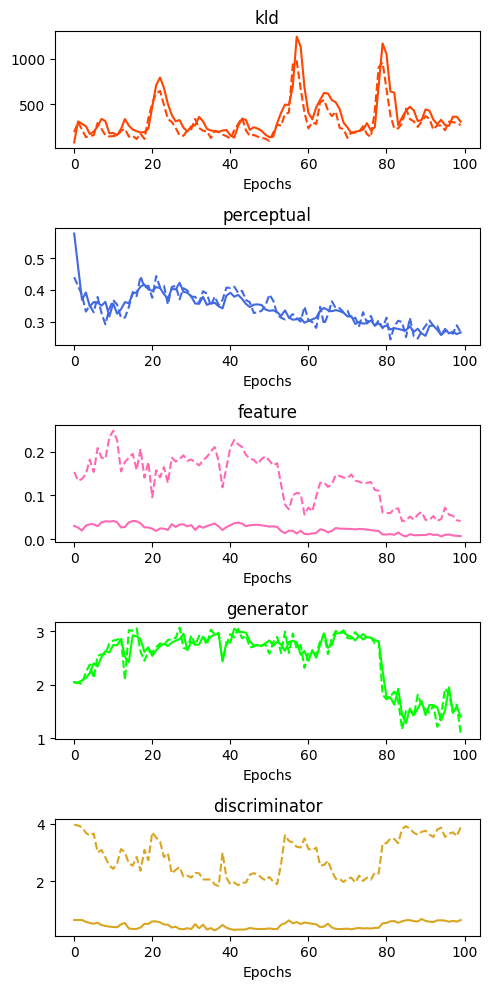

In [46]:
# Plot losses
colors = ["orangered", "royalblue", "hotpink", "lime", "goldenrod"]
plt.figure(figsize=(5, 10))
ind = 0
for key, val in losses.items():
    plt.subplot(len(losses.keys()), 1, ind + 1)
    plt.plot(val, color=colors[ind], linestyle="-")
    plt.plot(losses_val[key], color=colors[ind], linestyle="--")
    plt.title(key)
    plt.xlabel("Epochs")
    ind += 1
plt.tight_layout()
plt.show()